# Evaluating Sharpness Preservation

Get 10% and 50% MTFs for fbp, red-cnn, and red-cnn augmentation

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
base_dir = Path('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation')
phantom_dir = base_dir / 'CTP404_peds'
meta = pd.read_csv(phantom_dir / 'metadata.csv')
meta

Name phantom  effective diameter [cm]  FOV [cm]  \
0    35.0 mm CTP404  CTP404                     35.0      38.5   
1    35.0 mm CTP404  CTP404                     35.0      38.5   
2    35.0 mm CTP404  CTP404                     35.0      38.5   
3    35.0 mm CTP404  CTP404                     35.0      38.5   
4    35.0 mm CTP404  CTP404                     35.0      38.5   
..              ...     ...                      ...       ...   
187  15.1 mm CTP404  CTP404                     15.1      16.6   
188  15.1 mm CTP404  CTP404                     15.1      16.6   
189  15.1 mm CTP404  CTP404                     15.1      16.6   
190  15.1 mm CTP404  CTP404                     15.1      16.6   
191  15.1 mm CTP404  CTP404                     15.1      16.6   

                 recon  Dose [%]  \
0    RED-CNN augmented        10   
1              RED-CNN        10   
2                  fbp        10   
3    RED-CNN augmented        40   
4              RED-CNN        40   
..                 ...       ...   
187            RED-CNN        70   
188                fbp        70   
189  RED-CNN augmented        85   
190            RED-CNN        85   
191                fbp        85   

                                                  file  simulated kernel  \
0    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
1    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
2    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
3    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
4    /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
..                                                 ...        ...    ...   
187  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
188  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
189  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
190  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
191  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   

                        scanner  
0    Siemens Somatom Definition  
1    Siemens Somatom Definition  
2    Siemens Somatom Definition  
3    Siemens Somatom Definition  
4    Siemens Somatom Definition  
..                          ...  
187  Siemens Somatom Definition  
188  Siemens Somatom Definition  
189  Siemens Somatom Definition  
190  Siemens Somatom Definition  
191  Siemens Somatom Definition  

[192 rows x 10 columns]

1. move the CTP404 phantom simulations from `/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404` to `/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds` - **done**
2. add metaheaders to make them easier to load, with pixel size and recon info? -> dicom eventually for this last one - **done**
3. make metadata csv like for CCT189 - **done**

4. make sure Ct numbers have 0 offset, so air == -1000, water == 0 - **done**
5. run denoisers on the CTP dataset - **done**
6. then run /home/brandon.nelson/Dev/DLIR_Ped_Generalizability/geometric_phantom_studies/evaluation/MTF

In [3]:
import SimpleITK as sitk
vol = sitk.ReadImage(meta.file[0])
vol.GetDepth(), vol.GetWidth(), vol.GetHeight()

(20, 512, 512)

In [4]:
meta[(meta['Dose [%]']==25)&
     (meta['effective diameter [cm]']==35)&
     (meta['FOV [cm]']==38.5)]

Name phantom  effective diameter [cm]  FOV [cm]  \
9   35.0 mm CTP404  CTP404                     35.0      38.5   
10  35.0 mm CTP404  CTP404                     35.0      38.5   
11  35.0 mm CTP404  CTP404                     35.0      38.5   

                recon  Dose [%]  \
9   RED-CNN augmented        25   
10            RED-CNN        25   
11                fbp        25   

                                                 file  simulated kernel  \
9   /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
10  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   
11  /gpfs_projects/brandon.nelson/PediatricCTSizeD...       True    D45   

                       scanner  
9   Siemens Somatom Definition  
10  Siemens Somatom Definition  
11  Siemens Somatom Definition

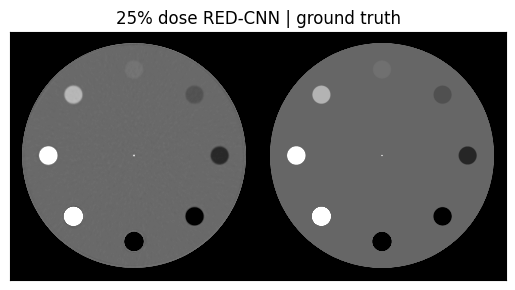

In [5]:
from results_utils import browse_studies, study_viewer
browse_studies(meta, phantom='CTP404', diameter=35, fov=38.5, dose=25, recon='RED-CNN')

In [6]:
study_viewer(meta)

interactive(children=(Dropdown(description='phantom', options=('CTP404',), value='CTP404'), Dropdown(descripti…

## Measuring MTF

### Selecting HU-Specific ROIs

In [7]:
from utils import get_ground_truth, load_mhd
import SimpleITK as sitk
row = meta[(meta['Dose [%]']==1000)&(meta['effective diameter [cm]']==35)].iloc[0]
file = row.file

gt_file = get_ground_truth(file)
file, gt_file

('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter350mm/dose_1000/RED-CNN augmented/350mm_dose_1000_RED-CNN augmented.mhd',
 PosixPath('/gpfs_projects/brandon.nelson/PediatricCTSizeDataAugmentation/CTP404_peds/diameter350mm/true.mhd'))

In [8]:
img = load_mhd(file)
gt_img = load_mhd(gt_file)

In [9]:
contrast_locations = pd.read_csv('/gpfs_projects/brandon.nelson/DLIR_Ped_Generalizability/geometric_phantom_studies/main/geometric/CTP404/monochromatic/diameter150mm/phantom_info_pix_idx.csv')
contrast_locations.rename(columns=dict(zip(contrast_locations.columns, list(map(lambda o: o.strip(), contrast_locations.columns)))), inplace=True)
water_attenuation_coefficient = contrast_locations[contrast_locations['x radius'] == contrast_locations['x radius'].max()]['mu [60 keV]'].item()
contrast_locations['Contrast [HU]'] = round((contrast_locations['mu [60 keV]'])/water_attenuation_coefficient*1000)
contrast_locations.loc[contrast_locations['mu [60 keV]']==water_attenuation_coefficient, 'Contrast [HU]'] = 0 
contrast_locations

x center  y center   x radius   y radius  angle degree  mu [60 keV]  \
0       256       256  112.94000  112.94000             0     0.020590   
1       256       342    9.03530    9.03530             0     0.000309   
2       317       317    9.03530    9.03530             0    -0.000721   
3       342       256    9.03530    9.03530             0    -0.002059   
4       317       195    9.03530    9.03530             0    -0.004118   
5       256       170    9.03530    9.03530             0    -0.020590   
6       195       195    9.03530    9.03530             0     0.020384   
7       170       256    9.03530    9.03530             0     0.007001   
8       195       317    9.03530    9.03530             0     0.002471   
9       256       256    0.37647    0.37647             0     0.123540   

   Contrast [HU]  
0            0.0  
1           15.0  
2          -35.0  
3         -100.0  
4         -200.0  
5        -1000.0  
6          990.0  
7          340.0  
8          120.0  
9         6000.0

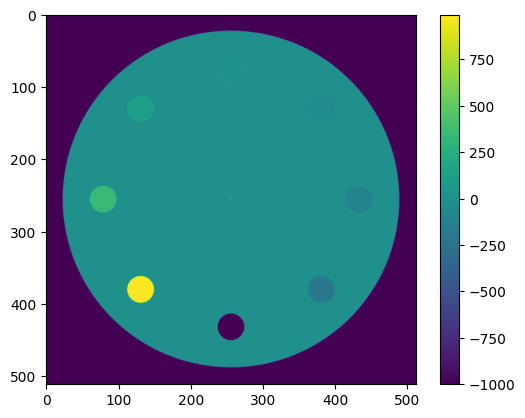

In [10]:
plt.imshow(gt_img)
plt.colorbar()

In [11]:
np.unique(gt_img), len(np.unique(gt_img))

(array([-1000,  -937,  -875,  -812,  -750,  -688,  -687,  -625,  -562,
         -500,  -437,  -375,  -312,  -250,  -200,  -187,  -175,  -163,
         -150,  -137,  -125,  -113,  -100,   -94,   -87,   -81,   -75,
          -69,   -63,   -62,   -56,   -50,   -44,   -38,   -37,   -35,
          -33,   -31,   -28,   -26,   -25,   -24,   -22,   -20,   -19,
          -18,   -17,   -15,   -13,   -12,   -11,    -9,    -6,    -4,
           -2,     0,     1,     2,     3,     4,     5,     6,     7,
            8,     9,    10,    11,    12,    13,    14,    15,    21,
           30,    38,    43,    45,    53,    60,    62,    64,    68,
           75,    83,    85,    90,    98,   105,   106,   113,   120,
          124,   128,   149,   170,   191,   213,   234,   247,   248,
          255,   276,   298,   309,   319,   340,   371,   375,   433,
          495,   557,   619,   681,   742,   743,   804,   866,   928,
          990], dtype=int16),
 118)

There should be no more than 10 unique values in the ground truth image (8 inserts + background + foreground)

In [12]:
row

Name                                                          35.0 mm CTP404
phantom                                                               CTP404
effective diameter [cm]                                                 35.0
FOV [cm]                                                                38.5
recon                                                      RED-CNN augmented
Dose [%]                                                                1000
file                       /gpfs_projects/brandon.nelson/PediatricCTSizeD...
simulated                                                               True
kernel                                                                   D45
scanner                                           Siemens Somatom Definition
Name: 6, dtype: object

88.41670439112721


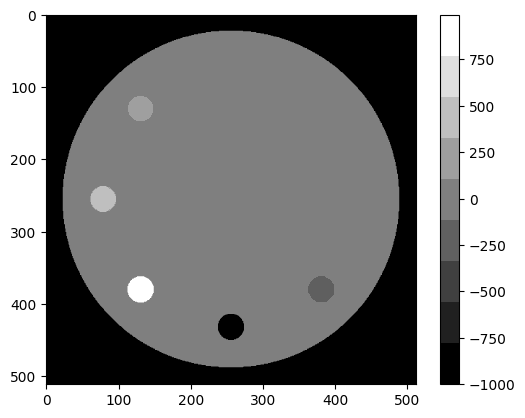

In [13]:
from skimage import measure
def deblur_ground_truth(gt_img, size_thresh=1000):
    label_image = measure.label(gt_img, background=-1000)
    mask = np.zeros_like(label_image)
    for label in np.unique(label_image):
        if (np.sum(label_image==label) < size_thresh): continue
        mask[label_image==label]=gt_img[label_image==label]
    return mask

pixel_size_mm = sitk.ReadImage(file).GetSpacing()[0]
min_area_mm2 = 50
size_thresh_pixels = min_area_mm2/(pixel_size_mm**2)
print(size_thresh_pixels)
gt_img = load_mhd(gt_file)
gt_img = deblur_ground_truth(gt_img, size_thresh=min_area_mm2/(pixel_size_mm**2))
plt.imshow(gt_img, cmap=plt.get_cmap('gray', len(np.unique(gt_img))))
plt.colorbar()

In [14]:
np.unique(gt_img), len(np.unique(gt_img))

(array([-1000,  -200,  -100,   -35,     0,    15,   120,   340,   990]), 9)

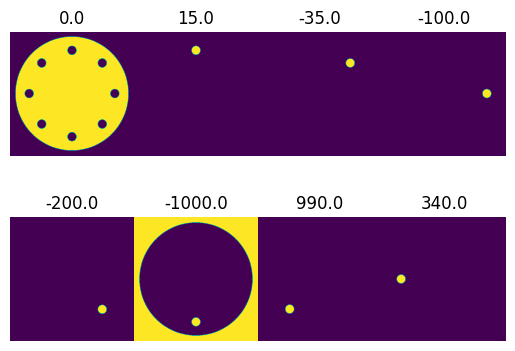

In [15]:
from skimage import data, util, measure
f, axs = plt.subplots(2,4, sharex=True, sharey=True, gridspec_kw=dict(hspace=0, wspace=0))
for ax, HU in zip(axs.flatten(), contrast_locations['Contrast [HU]']):
    ax.imshow(gt_img==HU) #label = 0 is background, 1 is the largest object
    ax.set_title(HU)
    ax.axis('off')

Now add radial averaging... and loop through all contrasts and do this for all recons to get ESF --> MTF --> MTF10, MTF50

In [16]:
import numpy as np

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

def radial_profile(img, center, radius, angle, num=None):
    if num is None:
        num = np.ceil(radius).astype(int)
    coords = np.round(np.array(list(map(lambda r: pol2cart(r, phi=angle), np.linspace(0, radius, num=num))))+center).astype(int) 
    return [img[x,y] for x, y in coords]

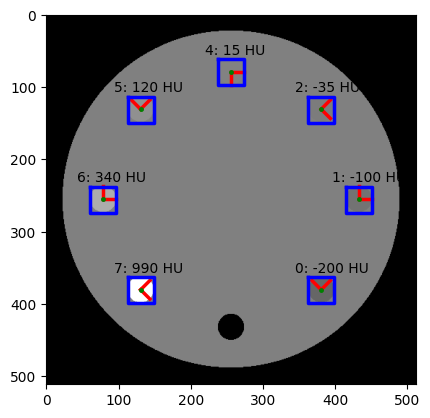

In [17]:
import math

regions = measure.regionprops(gt_img+1000)

fig, ax = plt.subplots()
ax.imshow(gt_img, cmap=plt.cm.gray)
for idx, props in enumerate(regions):
    if (props.label - 1000) == 0:
        continue
    y0, x0 = props.centroid
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.axis_minor_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.axis_minor_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.axis_major_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.axis_major_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
    ax.plot(x0, y0, '.g', markersize=5)
    ax.annotate(f'{idx}: {props.label-1000} HU', (x0-props.axis_major_length, y0-props.axis_major_length/1.5))

    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, '-b', linewidth=2.5)
plt.show()

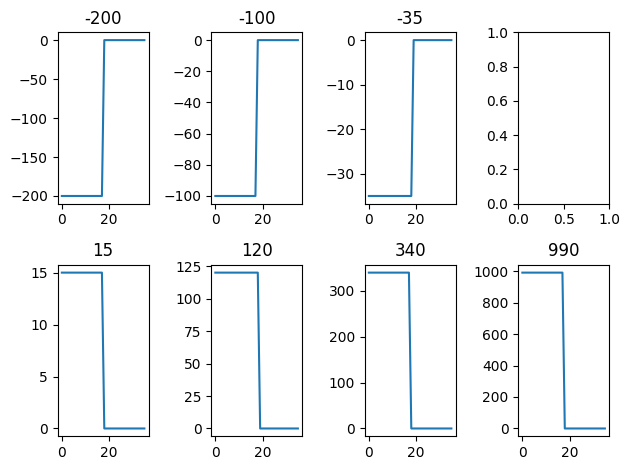

In [18]:
f, axs = plt.subplots(2, 4, tight_layout=True)
for ax, region in zip(axs.flatten(), regions):
    center = region.centroid
    contrast = region.label-1000
    if contrast == 0: continue
    radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
    x0 = round(center[0])
    x1 = int(x0 + 2*radius)
    y0 = round(center[1])
    y1 = int(y0 + 1)
    ax.plot(gt_img[x0:x1, y0:y1])
    ax.set_title(contrast)

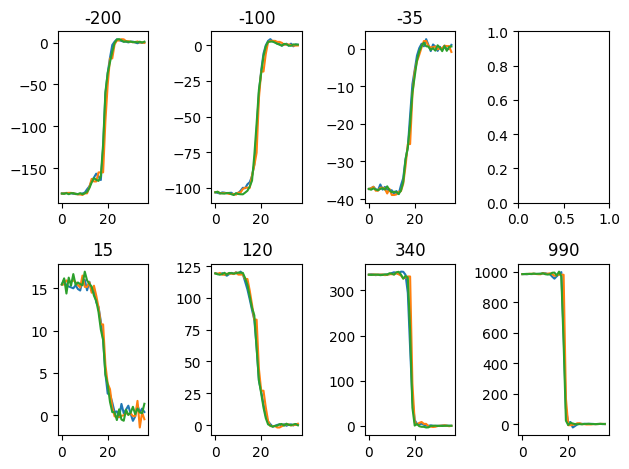

In [19]:
f, axs = plt.subplots(2, 4, tight_layout=True)
for deg in [0, 45, 90]:
    for ax, region in zip(axs.flatten(), regions):
        center = np.array(region.centroid)
        contrast = region.label-1000
        if contrast == 0: continue
        radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
        ax.plot(radial_profile(img[0], center, 2*radius, angle=np.deg2rad(deg)), label=deg)
        ax.set_title(contrast)
plt.show()

In [20]:
import seaborn as sns

def measure_esf(file, nangles=4):
    """
    Measures edqe spread functions at `nangles` equi-radially spaced for each contrast
    """
    distances = []
    profiles = []
    degrees = []
    contrasts = []
    series = []

    img = load_mhd(file)
    gt_img = load_mhd(get_ground_truth(file))
    pixel_size_mm = sitk.ReadImage(file).GetSpacing()[0]
    min_area_mm2 = 50
    size_thresh_pixels = min_area_mm2/(pixel_size_mm**2)
    gt_img = deblur_ground_truth(gt_img, size_thresh=size_thresh_pixels)

    regions = measure.regionprops(gt_img+1000)
    angles = np.linspace(0, 180, nangles)

    for region in regions:
        contrast = region.label - 1000
        if contrast == 0: continue
        center = region.centroid
        radius = np.mean([region.axis_major_length, region.axis_minor_length])/2
        for deg in angles:
            rad = np.deg2rad(deg)
            gt_profile = radial_profile(gt_img, center=center, radius=2*radius, angle=rad)
            img_profile = list(np.mean([radial_profile(repeat, center=center, radius=2*radius, angle=rad) for repeat in img], axis=0))
            degrees = degrees + len(gt_profile)*[deg] + len(img_profile)*[deg]
            distances = distances + list(range(len(gt_profile))) + list(range(len(img_profile)))
            profiles = profiles + gt_profile + img_profile
            contrasts = contrasts + len(gt_profile)*[contrast] + len(img_profile)*[contrast]
            series =  series + len(gt_profile)*['truth'] + len(img_profile)*['image']
    esf = pd.DataFrame({'series': series,
                        'contrast': contrasts,
                        'angle [degree]': degrees,
                        'distance': distances,
                        'ESF': profiles})
    return esf

file = meta[meta['Dose [%]']==1000].iloc[0].file
esf = measure_esf(file)
esf.head()

series  contrast  angle [degree]  distance    ESF
0  truth      -200             0.0         0 -200.0
1  truth      -200             0.0         1 -200.0
2  truth      -200             0.0         2 -200.0
3  truth      -200             0.0         3 -200.0
4  truth      -200             0.0         4 -200.0

In [21]:
esf.contrast.unique()

array([-200, -100,  -35,   15,  120,  340,  990])

In [22]:
-200, -35

(-200, -35)

<Axes: xlabel='distance', ylabel='ESF'>

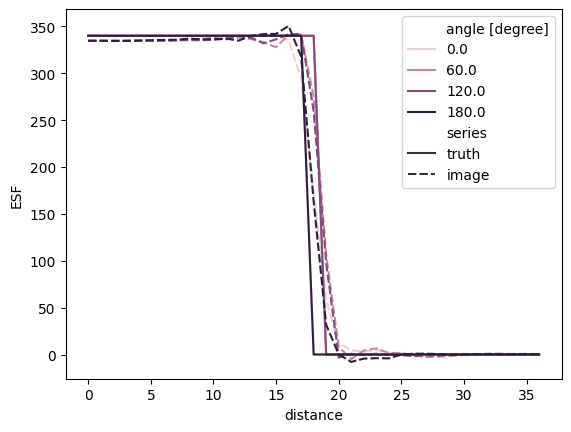

In [23]:
sns.lineplot(data=esf[(esf.contrast==340)], hue='angle [degree]', x='distance', y='ESF', style='series')

In [24]:
from tqdm import tqdm

df_list = []
for idx, row in tqdm(meta[meta['Dose [%]']==1000].iterrows()):
    file = row.file
    esf = measure_esf(file)
    esf['effective diameter [cm]']=row['effective diameter [cm]']
    esf['FOV [cm]']=row['FOV [cm]']
    esf['recon']=row['recon']
    esf.loc[esf['series']=='truth', 'recon'] = 'truth'
    esf['Dose [%]']=row['Dose [%]']
    df_list.append(esf)
esf = pd.concat(df_list, ignore_index=True)
esf

24it [00:06,  3.63it/s]


series  contrast  angle [degree]  distance     ESF  \
0      truth      -200             0.0         0 -200.00   
1      truth      -200             0.0         1 -200.00   
2      truth      -200             0.0         2 -200.00   
3      truth      -200             0.0         3 -200.00   
4      truth      -200             0.0         4 -200.00   
...      ...       ...             ...       ...     ...   
46531  image       990           180.0        32   -0.95   
46532  image       990           180.0        33    0.25   
46533  image       990           180.0        34    0.15   
46534  image       990           180.0        35    0.60   
46535  image       990           180.0        36    0.35   

       effective diameter [cm]  FOV [cm]  recon  Dose [%]  
0                         35.0      38.5  truth      1000  
1                         35.0      38.5  truth      1000  
2                         35.0      38.5  truth      1000  
3                         35.0      38.5  truth      1000  
4                         35.0      38.5  truth      1000  
...                        ...       ...    ...       ...  
46531                     15.1      16.6    fbp      1000  
46532                     15.1      16.6    fbp      1000  
46533                     15.1      16.6    fbp      1000  
46534                     15.1      16.6    fbp      1000  
46535                     15.1      16.6    fbp      1000  

[46536 rows x 9 columns]

In [25]:
esf.recon.unique()

array(['truth', 'RED-CNN augmented', 'RED-CNN', 'fbp'], dtype=object)

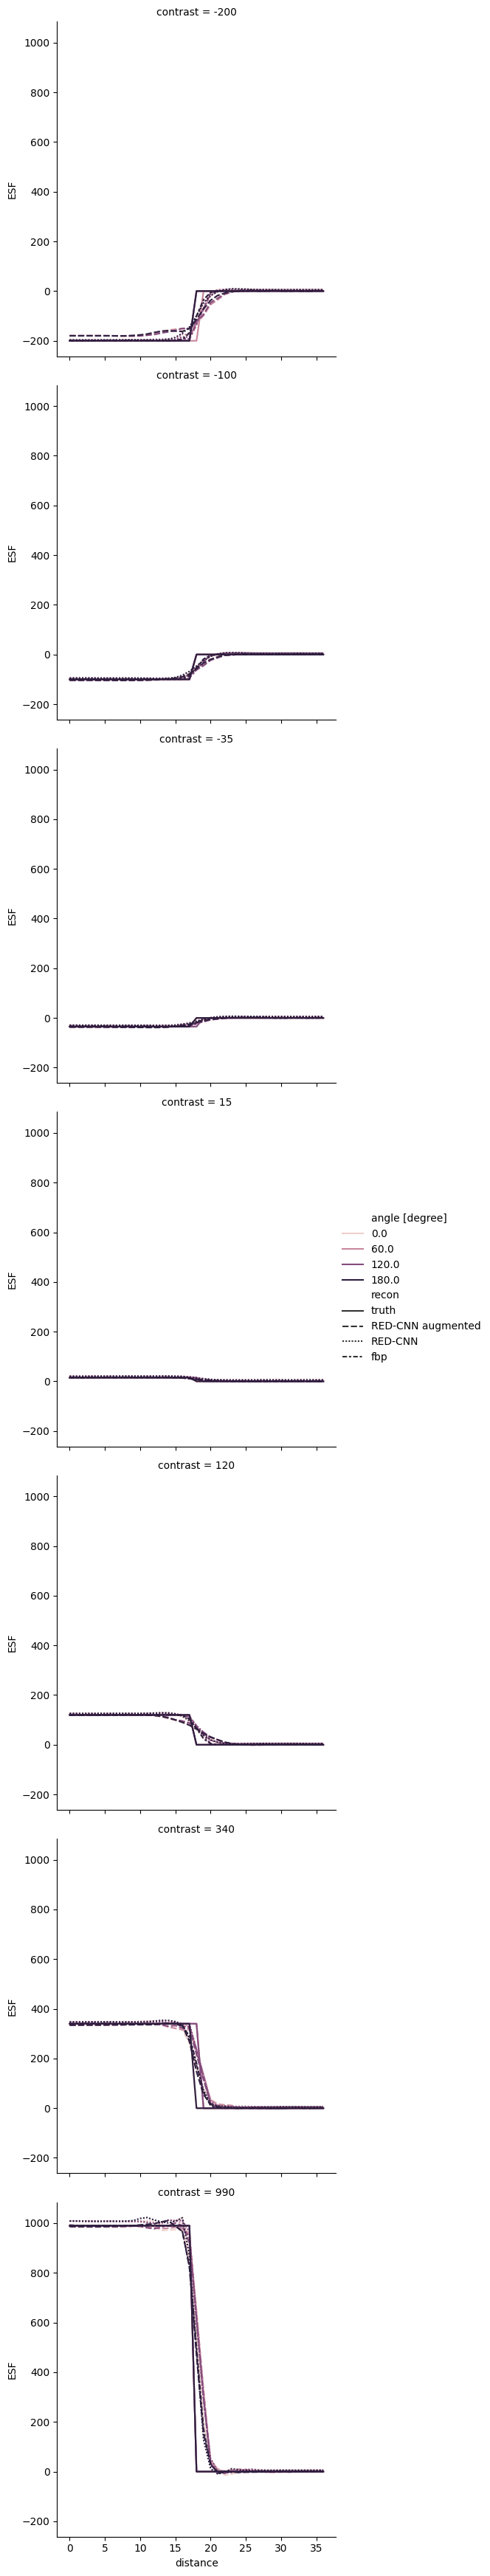

In [26]:
sns.relplot(data=esf[esf['effective diameter [cm]']==15.1], x='distance', y='ESF', hue='angle [degree]', style='recon', kind='line', row='contrast')

### Average across angles

In [27]:
def measure_averaged_esf(file, nangles=180):
    esf = measure_esf(file, nangles=nangles)
    radial_mean_esf = esf.groupby(['series', 'contrast', 'distance']).mean('ESF')
    df_list = []
    for series in esf['series'].unique():
        for contrast in esf['contrast'].unique():
            temp = esf[(esf['series']==series)&(esf['contrast']==contrast)&(esf['angle [degree]']==0)].copy().set_index('distance')
            temp.pop('angle [degree]')
            temp['ESF'] = radial_mean_esf['ESF'][series, contrast]
            df_list.append(temp.reset_index())
    return pd.concat(df_list, ignore_index=True)

In [28]:
avg_esf = measure_averaged_esf(file)
avg_esf

distance series  contrast         ESF
0           0  truth      -200 -200.000000
1           1  truth      -200 -200.000000
2           2  truth      -200 -200.000000
3           3  truth      -200 -200.000000
4           4  truth      -200 -200.000000
..        ...    ...       ...         ...
513        32  image       990   -0.048889
514        33  image       990    0.093056
515        34  image       990    0.140000
516        35  image       990    0.114444
517        36  image       990    0.005000

[518 rows x 4 columns]

In [29]:
avg_esf[avg_esf.contrast==-100]

distance series  contrast         ESF
37          0  truth      -100 -100.000000
38          1  truth      -100 -100.000000
39          2  truth      -100 -100.000000
40          3  truth      -100 -100.000000
41          4  truth      -100 -100.000000
..        ...    ...       ...         ...
328        32  image      -100    0.111389
329        33  image      -100    0.170833
330        34  image      -100    0.148889
331        35  image      -100    0.061111
332        36  image      -100    0.138611

[74 rows x 4 columns]

<Axes: xlabel='distance', ylabel='ESF'>

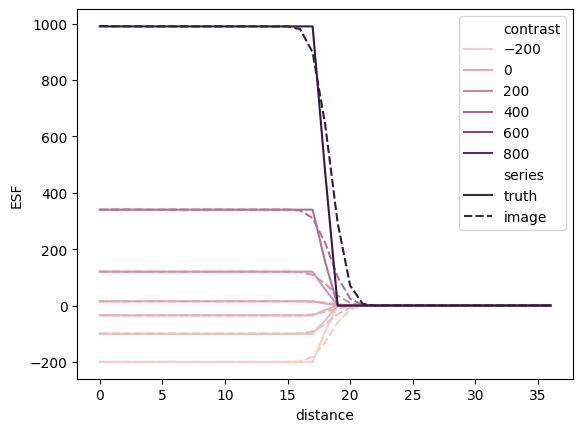

In [30]:
avg_esf = measure_averaged_esf(file, nangles=180)
sns.lineplot(data=avg_esf, x='distance', y='ESF', hue='contrast', style='series')

In [31]:
from tqdm import tqdm
nangles=180

esf_csv = Path('esf.csv')

if not esf_csv.exists():
    df_list = []
    for idx, row in tqdm(meta.iterrows()):
        file = row.file
        avg_esf = measure_averaged_esf(file, nangles=180)
        avg_esf['effective diameter [cm]']=row['effective diameter [cm]']
        avg_esf['FOV [cm]']=row['FOV [cm]']
        avg_esf['recon']=row['recon']
        avg_esf.loc[avg_esf['series']=='truth', 'recon'] = 'truth'
        avg_esf['Dose [%]']=row['Dose [%]']
        df_list.append(avg_esf)
    avg_esf = pd.concat(df_list, ignore_index=True)
    avg_esf['distance [cm]'] = avg_esf['distance'] * avg_esf['FOV [cm]']/512
    avg_esf.rename(columns={'distance':'distance [pixels]'})
    avg_esf.to_csv(esf_csv, index=False)

avg_esf = pd.read_csv(esf_csv)
avg_esf

distance series  contrast         ESF  effective diameter [cm]  \
0             0  truth      -200 -200.000000                     35.0   
1             1  truth      -200 -200.000000                     35.0   
2             2  truth      -200 -200.000000                     35.0   
3             3  truth      -200 -200.000000                     35.0   
4             4  truth      -200 -200.000000                     35.0   
...         ...    ...       ...         ...                      ...   
93067        32  image       990    0.251389                     15.1   
93068        33  image       990    0.428056                     15.1   
93069        34  image       990    0.437778                     15.1   
93070        35  image       990   -0.011944                     15.1   
93071        36  image       990   -0.282778                     15.1   

       FOV [cm]  recon  Dose [%]  distance [cm]  
0          38.5  truth        10       0.000000  
1          38.5  truth        10       0.075195  
2          38.5  truth        10       0.150391  
3          38.5  truth        10       0.225586  
4          38.5  truth        10       0.300781  
...         ...    ...       ...            ...  
93067      16.6    fbp        85       1.037500  
93068      16.6    fbp        85       1.069922  
93069      16.6    fbp        85       1.102344  
93070      16.6    fbp        85       1.134766  
93071      16.6    fbp        85       1.167188  

[93072 rows x 9 columns]

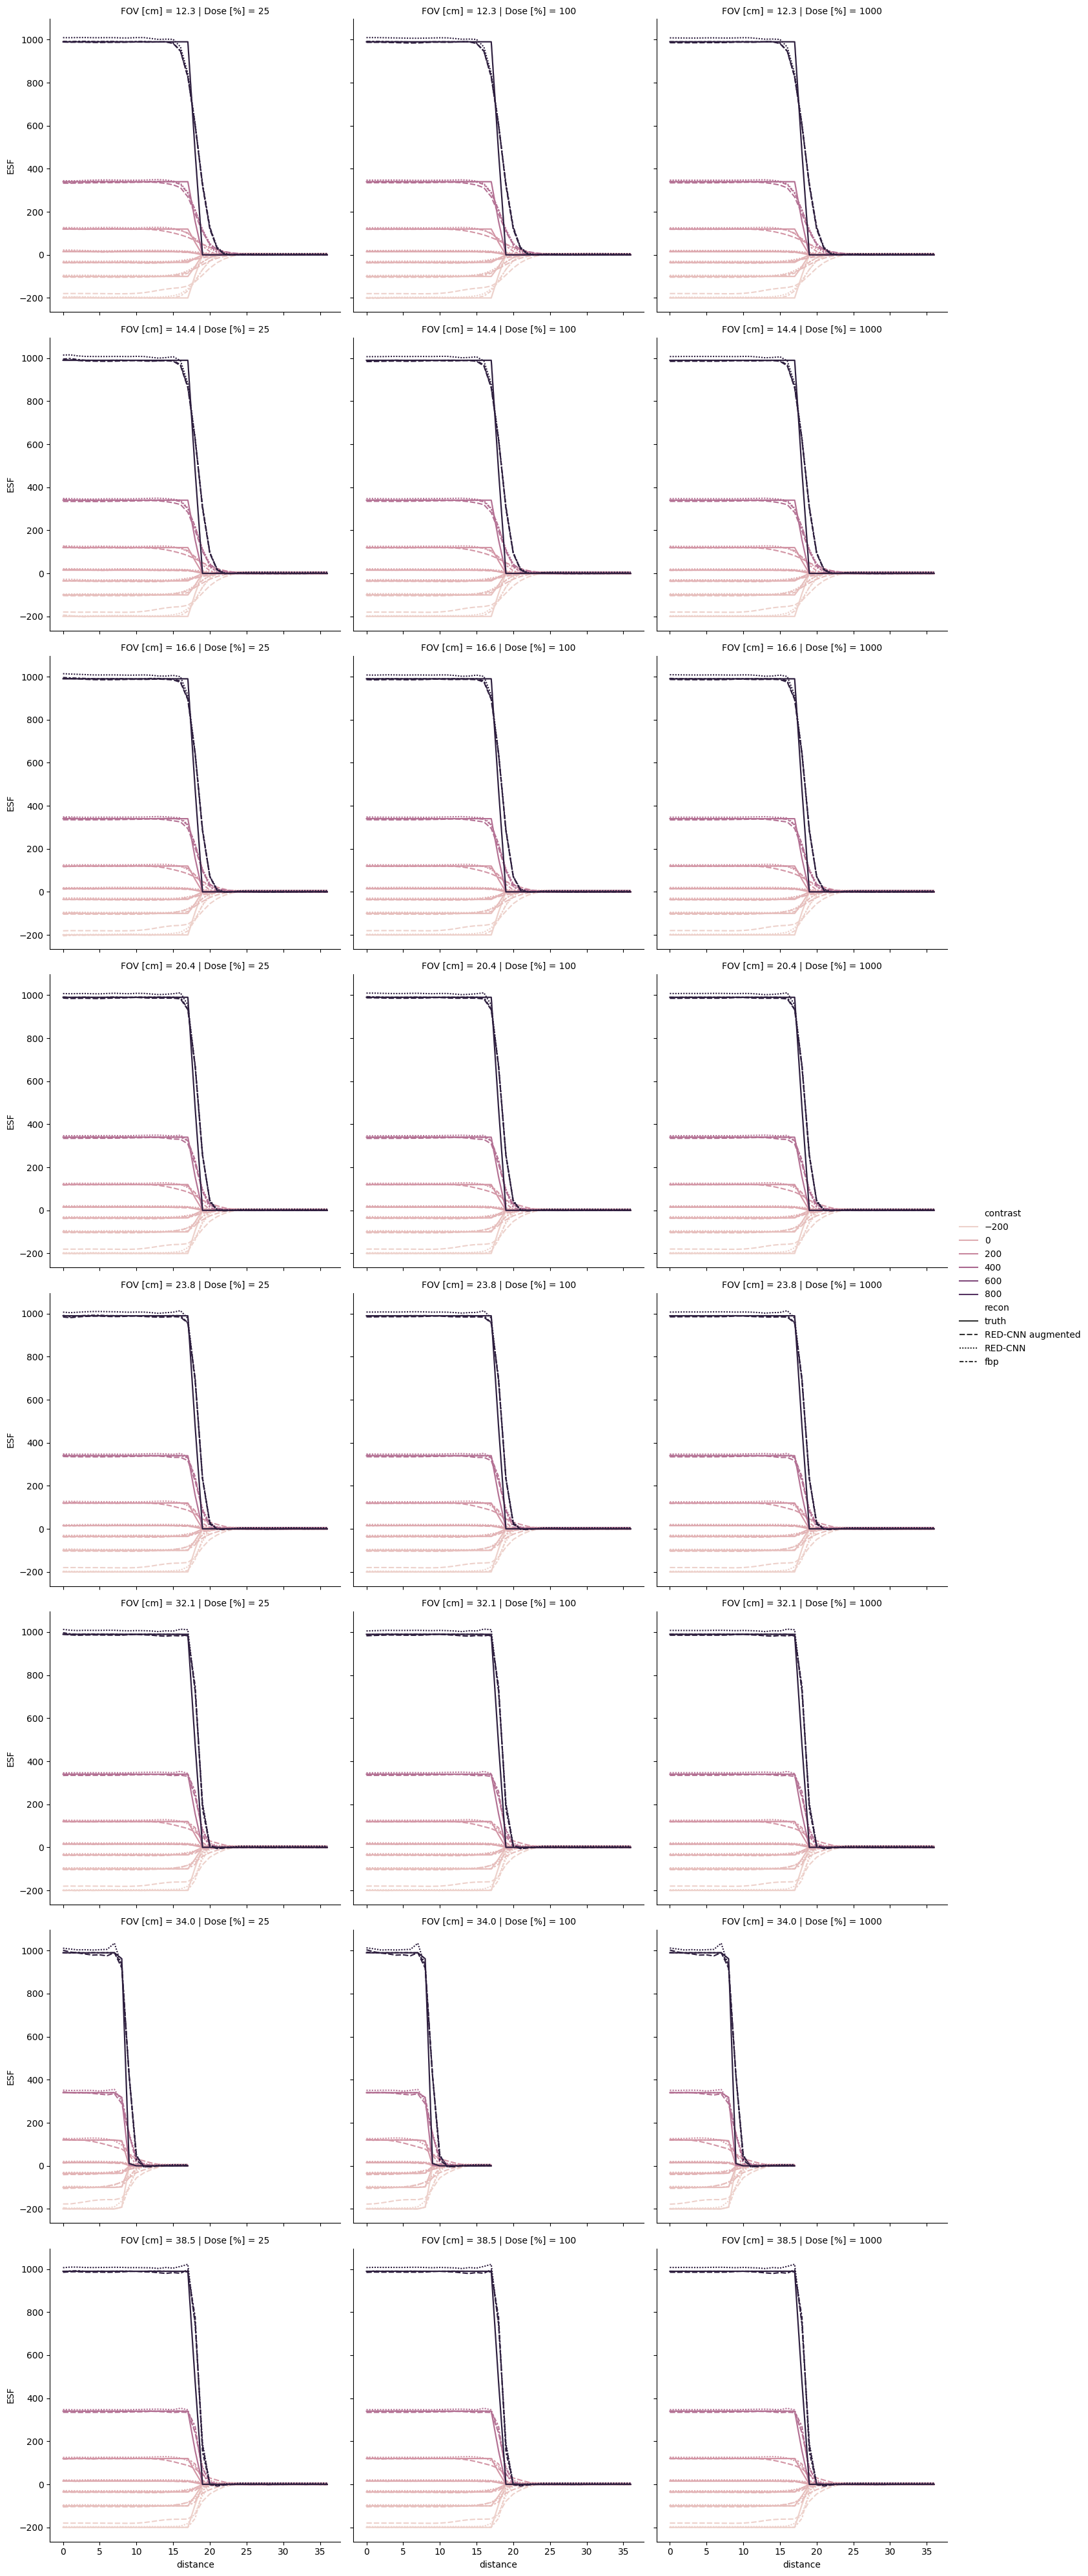

In [32]:
sns.relplot(data=avg_esf[avg_esf['Dose [%]'].isin([25, 100, 1000])], x='distance', y='ESF', hue='contrast', style='recon', kind='line', row='FOV [cm]', col='Dose [%]')

In [33]:
avg_esf['effective diameter [cm]'].unique()

array([35. , 15. , 11.2, 18.5, 21.6, 13.1, 29.2, 15.1])

In [34]:
avg_esf.contrast.unique()

array([-200, -100,  -35,   15,  120,  340,  990])

Text(0, 0.5, 'CT Number [HU]')

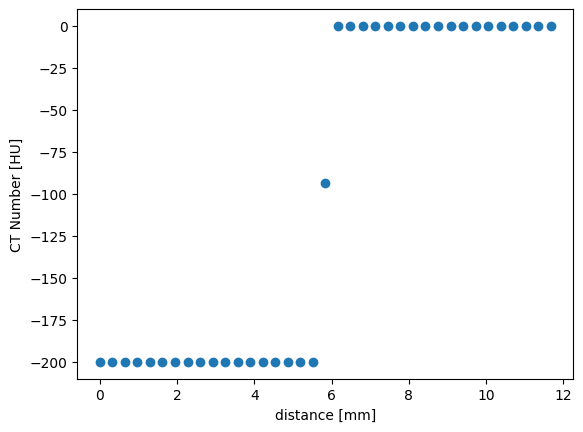

In [35]:
# avg_esf.pop('series')

esf = avg_esf[(avg_esf['contrast']==-200)&(avg_esf['effective diameter [cm]']==15.1)&(avg_esf['recon']=='truth')&(avg_esf['Dose [%]']==100)].drop_duplicates()
pixel_size_mm = esf['FOV [cm]'].iloc[0]/512 * 10
distance = esf['distance'].to_numpy()
distance_mm = esf['distance [cm]'].to_numpy() * 10
esf_profile = esf['ESF'].to_numpy()
plt.scatter(distance_mm, esf_profile)
plt.xlabel('distance [mm]')
plt.ylabel('CT Number [HU]')

In [36]:
esf['distance'].to_numpy()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36])

In [37]:
len(distance_mm)

37

In [38]:
from scipy import interpolate
sub_vox_sz = 0.01
interpolator_pix = interpolate.interp1d(distance, esf_profile)
interpolator = interpolate.interp1d(distance_mm, esf_profile)
oversampled_distance_mm = np.arange(distance_mm.min(), distance_mm.max(), step=sub_vox_sz)
oversampled_distance_pix = np.linspace(distance.min(), distance.max(), num=len(oversampled_distance_mm))

oversampled_esf = interpolator(oversampled_distance_mm)

Text(0, 0.5, 'CT Number [HU]')

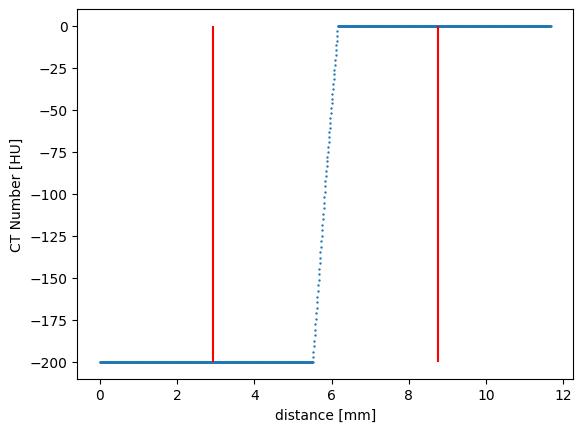

In [39]:
rel_dist_from_ends_for_means = 0.25 # larger number includes more values but risks getting to close to the edge
plt.scatter(oversampled_distance_mm, oversampled_esf, s=0.5)
plt.vlines(oversampled_distance_mm[round(len(oversampled_distance_mm)*rel_dist_from_ends_for_means)], ymin=oversampled_esf.min(), ymax=oversampled_esf.max(), color='red')
plt.vlines(oversampled_distance_mm[round(-len(oversampled_esf)*rel_dist_from_ends_for_means)], ymin=oversampled_esf.min(), ymax=oversampled_esf.max(), color='red')
plt.xlabel('distance [mm]')
plt.ylabel('CT Number [HU]')

To get the mean signal and background values average the values outside of the red lines, (equal to step 3 in [Friedman 2013](https://onlinelibrary.wiley.com/doi/abs/10.1118/1.4800795))

Now normalize so signal = 1 and background = 0 (still step 3)

0.0 -200.0


Text(0, 0.5, 'CT Number [HU]')

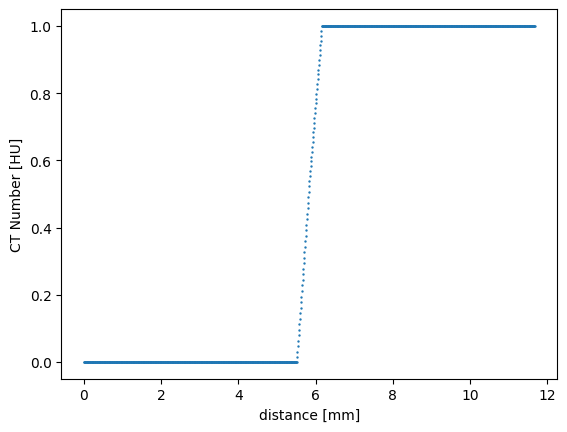

In [40]:
rel_dist_from_ends_for_means = 0.25 # larger number includes more values but risks getting to close to the edge
oversampled_esf = interpolator(oversampled_distance_mm)
mean_signal = oversampled_esf[:round(len(oversampled_distance_mm)*rel_dist_from_ends_for_means)].mean()
mean_bkg = oversampled_esf[round(-len(oversampled_esf)*rel_dist_from_ends_for_means):-1].mean()

oversampled_esf = (oversampled_esf - oversampled_esf.min())/(oversampled_esf.max() - oversampled_esf.min()) #eq. 4 Friedman 2013
# oversampled_esf = 1 - (mean_bkg - oversampled_esf)/(mean_bkg - mean_signal)
print(mean_bkg, mean_signal)
if mean_bkg < mean_signal:
    oversampled_esf= 1 - oversampled_esf

plt.scatter(oversampled_distance_mm, oversampled_esf, s=0.5)
plt.xlabel('distance [mm]')
plt.ylabel('CT Number [HU]')

esf_profileke the derivative and apply a Hann window

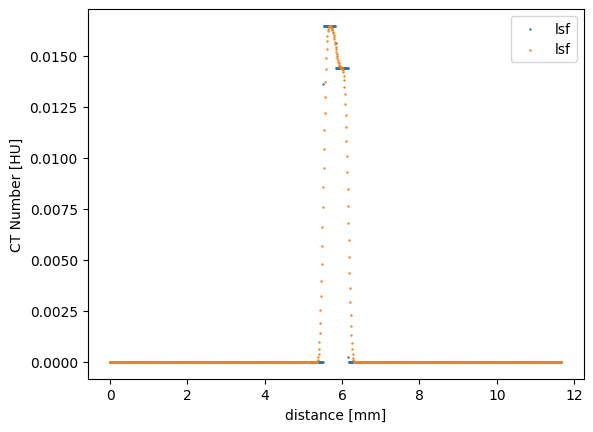

In [41]:
rel_hann_width = 0.03

# plt.scatter(oversampled_distance_mm, oversampled_esf, s=0.5, label='esf')
from scipy import signal
lsf = np.diff(oversampled_esf)
hann_width = round(len(lsf)*rel_hann_width)
win = signal.windows.hann(hann_width)
filtered_lsf = signal.convolve(lsf, win, mode='same') / sum(win)

plt.xlabel('distance [mm]')
plt.ylabel('CT Number [HU]')
plt.scatter(oversampled_distance_mm[:-1], lsf, s=0.5, label='lsf')
plt.scatter(oversampled_distance_mm[:-1], filtered_lsf, s=0.5, label='lsf')

plt.legend()

**Get spatial frequencies for both pixels and mm and save both to dataframes**

In [42]:
def distance_to_spatial_frequencies(distance_array):
    delta_freq = 1/distance_array.max()
    max_freq = 1/np.diff(distance_array)[0]
    sampled_freq = np.arange(0, max_freq, delta_freq)
    return sampled_freq

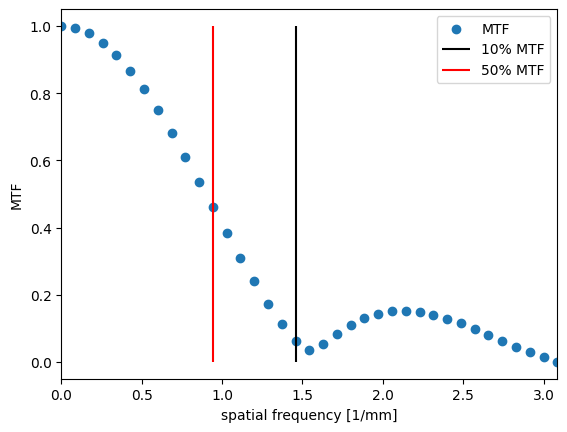

In [43]:
# mtf = mtf[:len(mtf)//2]
freq_invmm = distance_to_spatial_frequencies(oversampled_distance_mm)
freq_invpx = distance_to_spatial_frequencies(oversampled_distance_pix)
cutoff_freq = 1/pixel_size_mm
mtf = np.abs(np.fft.fft(filtered_lsf))

plt.scatter(freq_invmm, mtf, label='MTF')
plt.vlines(freq_invmm[np.argwhere(mtf<0.1)[0]], ymin=0, ymax=1, label='10% MTF', color='black')
plt.vlines(freq_invmm[np.argwhere(mtf<0.5)[0]], ymin=0, ymax=1, label='50% MTF', color='red')
plt.xlim([0, cutoff_freq])
plt.xlabel('spatial frequency [1/mm]')
plt.ylabel('MTF')
plt.legend()

https://onlinelibrary.wiley.com/doi/abs/10.1118/1.4800795 see on MTF

package into function

In [44]:
cutoff_freq_idx=np.argwhere(freq_invmm > cutoff_freq).squeeze()[0]
mtf_df = pd.DataFrame({'spatial frequency [1/mm]': freq_invmm[:cutoff_freq_idx],
                       'spatial frequency [1/px]': freq_invpx[:cutoff_freq_idx],
                       'MTF': mtf[:cutoff_freq_idx]})
mtf_df.head()

spatial frequency [1/mm]  spatial frequency [1/px]       MTF
0                  0.000000                  0.000000  1.000000
1                  0.085690                  0.027778  0.994402
2                  0.171380                  0.055556  0.977733
3                  0.257069                  0.083333  0.950372
4                  0.342759                  0.111111  0.912934

Now add columns for FOV, diameter, recon, dose and append all...

<Axes: xlabel='spatial frequency [1/px]'>

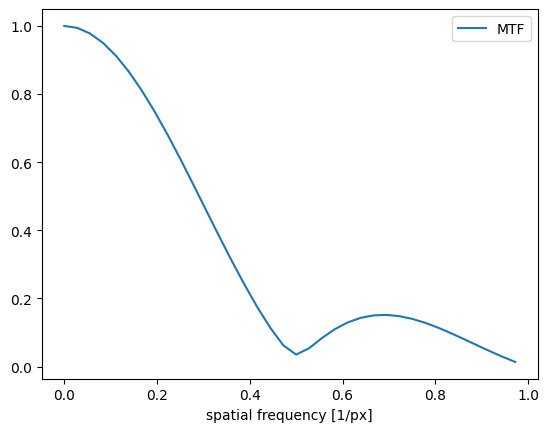

In [45]:
mtf_df.plot(x='spatial frequency [1/px]', y='MTF')

In [46]:
from scipy import interpolate, signal

def measure_mtf(esf, distance=None, oversampling=75):
    """
    Compute the modulation transfer function.
    
    Computed the MTF from an edge spread function. Implementation adapted from Friedman et al 2013

    Parameters
    ----------
    esf : array_like
    edge spread function (esf)
    
    distance : array_like, optional
    distance array (pixels, mm, cm, ...) of distances from start to end of the esf

    Friedman SN, Fung GSK, Siewerdsen JH, Tsui BMW.
    A simple approach to measure computed tomography (CT) modulation transfer function (MTF) and noise-power spectrum (NPS) using the American College of Radiology (ACR) accreditation phantom. [Medical Physics. 2013;40(5):051907.
    doi:10.1118/1.4800795](https://onlinelibrary.wiley.com/doi/abs/10.1118/1.4800795)
    """
    
    # interpolate esf
    if distance is None:
        distance = np.array(list(range(len(esf))))
    pixel_size = np.diff(distance)[0]
    
    interpolator = interpolate.interp1d(distance, esf)
    oversampled_distance = np.linspace(distance.min(), distance.max(), num=len(distance)*oversampling) #step 5 Friedman 2013
    oversampled_esf = interpolator(oversampled_distance)
    
    # normalize esf to within [0, 1] with transition
    rel_dist_from_ends_for_means = 0.25 # larger number includes more values but risks getting to close to the edge
    oversampled_esf = interpolator(oversampled_distance)
    mean_signal = oversampled_esf[:round(len(oversampled_distance)*rel_dist_from_ends_for_means)].mean()
    mean_bkg = oversampled_esf[round(-len(oversampled_esf)*rel_dist_from_ends_for_means):-1].mean()
    
    oversampled_esf = (oversampled_esf - oversampled_esf.min())/(oversampled_esf.max() - oversampled_esf.min()) #eq. 4 Friedman 2013
    
    # ensures signal goes from low signal to high signal for positive derivative when calculating line spread function
    if mean_bkg < mean_signal:
        oversampled_esf = 1 - oversampled_esf
    
    # ESF --> LSF step 6
    
    lsf = np.diff(oversampled_esf)
    
    # hann windowing step 7
    rel_hann_width = 0.03
    hann_width = round(len(lsf)*rel_hann_width)
    win = signal.windows.hann(hann_width)
    filtered_lsf = signal.convolve(lsf, win, mode='same') / sum(win)
    
    # calculate mtf as modulus of fft
    mtf = np.abs(np.fft.fft(filtered_lsf))
    freq = distance_to_spatial_frequencies(oversampled_distance)
    cutoff_freq = 1/pixel_size
    cutoff_freq_idx=np.argwhere(freq >= cutoff_freq).squeeze()[0]
    
    return mtf[:cutoff_freq_idx], freq[:cutoff_freq_idx]

In [47]:
avg_esf['contrast'].unique()

array([-200, -100,  -35,   15,  120,  340,  990])

The negative values are good, but there's something up with the 15. 120. 340, 990 not have MTF 1 at 0 freq

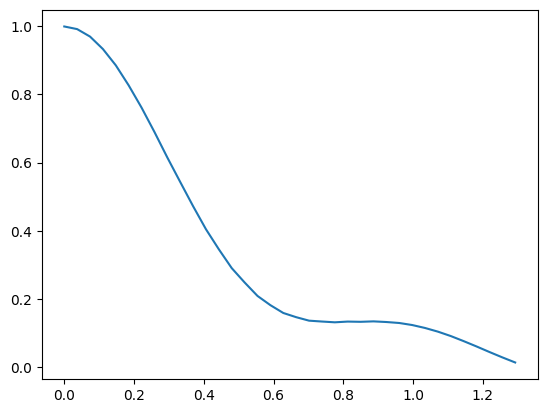

In [48]:
esf = avg_esf[(avg_esf['contrast']==990)&(avg_esf['effective diameter [cm]']==35)&(avg_esf['recon']=='fbp')&(avg_esf['Dose [%]']==1000)]
distance = esf['distance'].to_numpy()
distance_mm = esf['distance [cm]'].to_numpy() * 10
esf_profile = esf['ESF'].to_numpy()

m, f = measure_mtf(esf_profile, distance_mm)
plt.plot(f, m)
plt.show()

Double check ground truth as this should be 1 or close

In [49]:
avg_esf

distance series  contrast         ESF  effective diameter [cm]  \
0             0  truth      -200 -200.000000                     35.0   
1             1  truth      -200 -200.000000                     35.0   
2             2  truth      -200 -200.000000                     35.0   
3             3  truth      -200 -200.000000                     35.0   
4             4  truth      -200 -200.000000                     35.0   
...         ...    ...       ...         ...                      ...   
93067        32  image       990    0.251389                     15.1   
93068        33  image       990    0.428056                     15.1   
93069        34  image       990    0.437778                     15.1   
93070        35  image       990   -0.011944                     15.1   
93071        36  image       990   -0.282778                     15.1   

       FOV [cm]  recon  Dose [%]  distance [cm]  
0          38.5  truth        10       0.000000  
1          38.5  truth        10       0.075195  
2          38.5  truth        10       0.150391  
3          38.5  truth        10       0.225586  
4          38.5  truth        10       0.300781  
...         ...    ...       ...            ...  
93067      16.6    fbp        85       1.037500  
93068      16.6    fbp        85       1.069922  
93069      16.6    fbp        85       1.102344  
93070      16.6    fbp        85       1.134766  
93071      16.6    fbp        85       1.167188  

[93072 rows x 9 columns]

TODO: make unique labels for each line profile so they are easier to select eg: 15 cm fbp dose 100 80 contrast (or a integer id)

In [50]:
diameters = []
fovs = []
doses = []
recons = []
contrasts = []
frequencies_invcm = []
frequencies_invpix = []
mtfs = []
names = []

for diameter in tqdm(avg_esf['effective diameter [cm]'].unique()):
    temp = avg_esf[avg_esf['effective diameter [cm]']==diameter]
    for fov in temp['FOV [cm]'].unique():
        temp = temp[temp['FOV [cm]']==fov].copy()
        for dose in temp['Dose [%]'].unique():
            for recon in temp['recon'].unique():
                for contrast in temp['contrast'].unique():
                    esf = temp[(temp['FOV [cm]']==fov)&(temp['Dose [%]']==dose)&(temp['recon']==recon)&(temp['contrast']==contrast)].drop_duplicates()
                    distance_px = esf['distance'].to_numpy()
                    distance_cm = esf['distance [cm]'].to_numpy()
                    esf_profile = esf['ESF'].to_numpy()
                    assert(len(distance_px) == len(distance_cm))
                    assert(len(np.unique(distance_px)) == len(distance_px))

                    mtf, freq_invcm = measure_mtf(esf_profile, distance_cm)
                    mtf_px, freq_invpx = measure_mtf(esf_profile, distance_px)
                    if len(freq_invcm) < len(freq_invpx):
                        freq_invcm = np.append(freq_invcm, freq_invcm[-1]+np.diff(freq_invcm)[0])
                        mtf = np.append(mtf, 0)
                    elif len(freq_invcm) > len(freq_invpx):
                        freq_invpx = np.append(freq_invpx, freq_invpx[-1]+np.diff(freq_invpx)[0])
                        mtf_px = np.append(mtf_px, 0)
                    assert(len(freq_invcm) == len(freq_invpx))
                    name = f'{diameter} cm {dose}% dose {recon} {contrast} HU'
                    names += len(mtf)*[name]
                    diameters += len(mtf)*[diameter]
                    fovs += len(mtf)*[fov]
                    doses += len(mtf)*[dose]
                    recons += len(mtf)*[recon]
                    contrasts += len(mtf)*[contrast]
                    frequencies_invcm += list(freq_invcm)
                    frequencies_invpix += list(freq_invpx)
                    mtfs += list(mtf)
mtf_df = pd.DataFrame({'name': names,
                       'effective diameter [cm]': diameters,
                       'FOV [cm]': fovs,
                       'Dose [%]': doses,
                       'recon': recons,
                       'contrast': contrasts,
                       'spatial frequency [1/mm]': frequencies_invcm,
                       'spatial frequency [1/px]': frequencies_invpix,
                       'MTF': mtfs})
mtf_df

100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.59it/s]


name  effective diameter [cm]  FOV [cm]  \
0      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
1      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
2      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
3      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
4      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
...                               ...                      ...       ...   
60475     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
60476     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
60477     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
60478     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
60479     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   

       Dose [%]  recon  contrast  spatial frequency [1/mm]  \
0            10  truth      -200                  0.000000   
1            10  truth      -200                  0.369408   
2            10  truth      -200                  0.738817   
3            10  truth      -200                  1.108225   
4            10  truth      -200                  1.477633   
...         ...    ...       ...                       ...   
60475        85    fbp       990                 26.559572   
60476        85    fbp       990                 27.416332   
60477        85    fbp       990                 28.273092   
60478        85    fbp       990                 29.129853   
60479        85    fbp       990                 29.986613   

       spatial frequency [1/px]       MTF  
0                      0.000000  1.000000  
1                      0.027778  0.994387  
2                      0.055556  0.977677  
3                      0.083333  0.950248  
4                      0.111111  0.912723  
...                         ...       ...  
60475                  0.861111  0.055145  
60476                  0.888889  0.048979  
60477                  0.916667  0.039493  
60478                  0.944444  0.026902  
60479                  0.972222  0.013206  

[60480 rows x 9 columns]

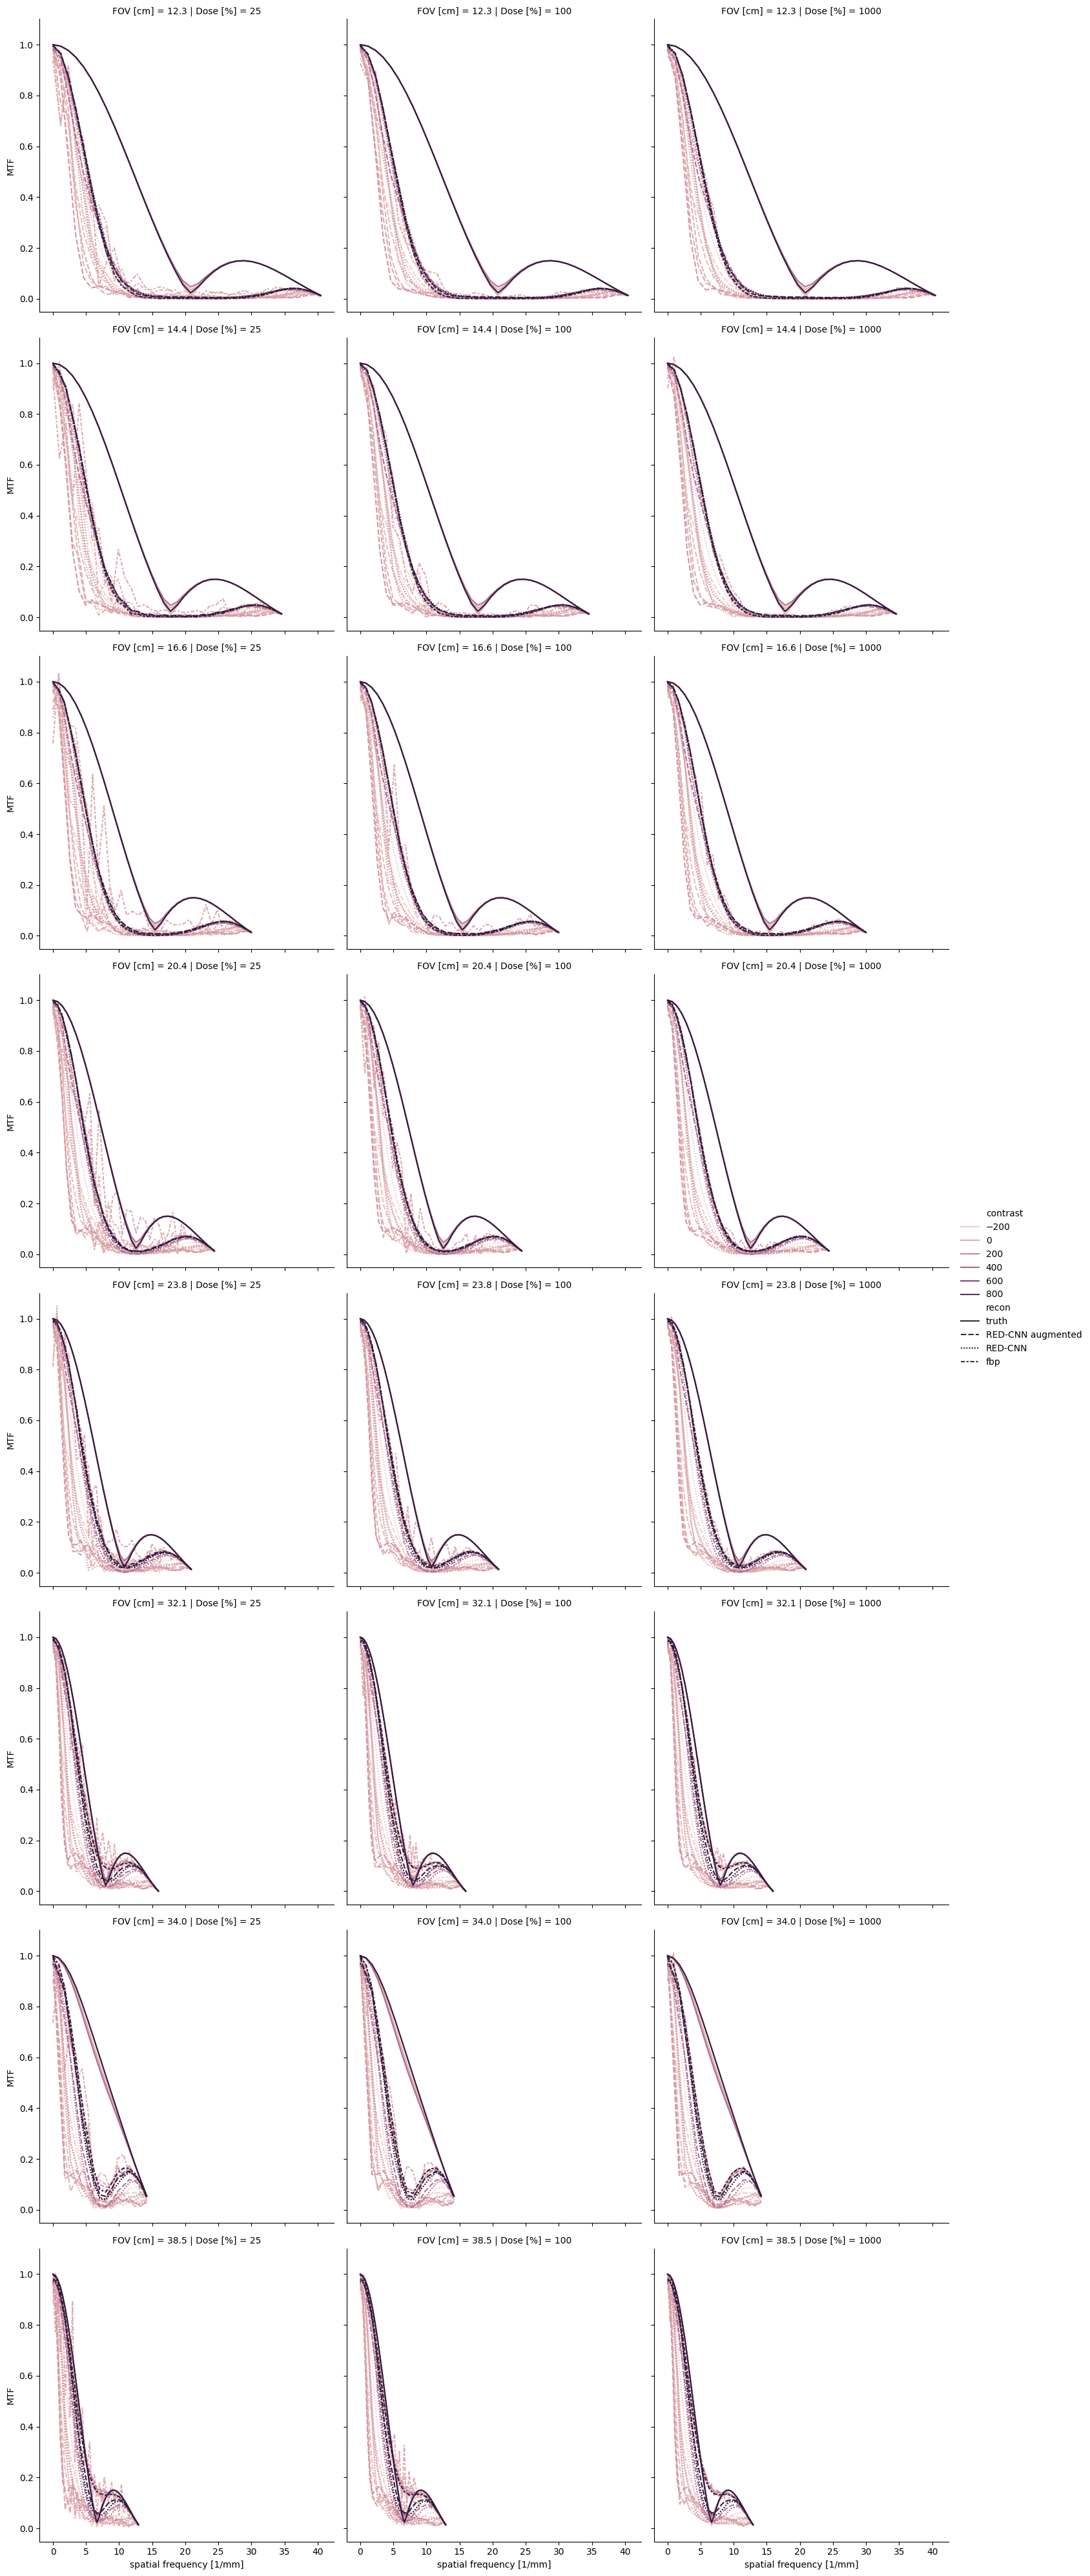

In [51]:
sns.relplot(data=mtf_df[mtf_df['Dose [%]'].isin([25, 100, 1000])], x='spatial frequency [1/mm]', y='MTF', hue='contrast', style='recon', kind='line', row='FOV [cm]', col='Dose [%]')

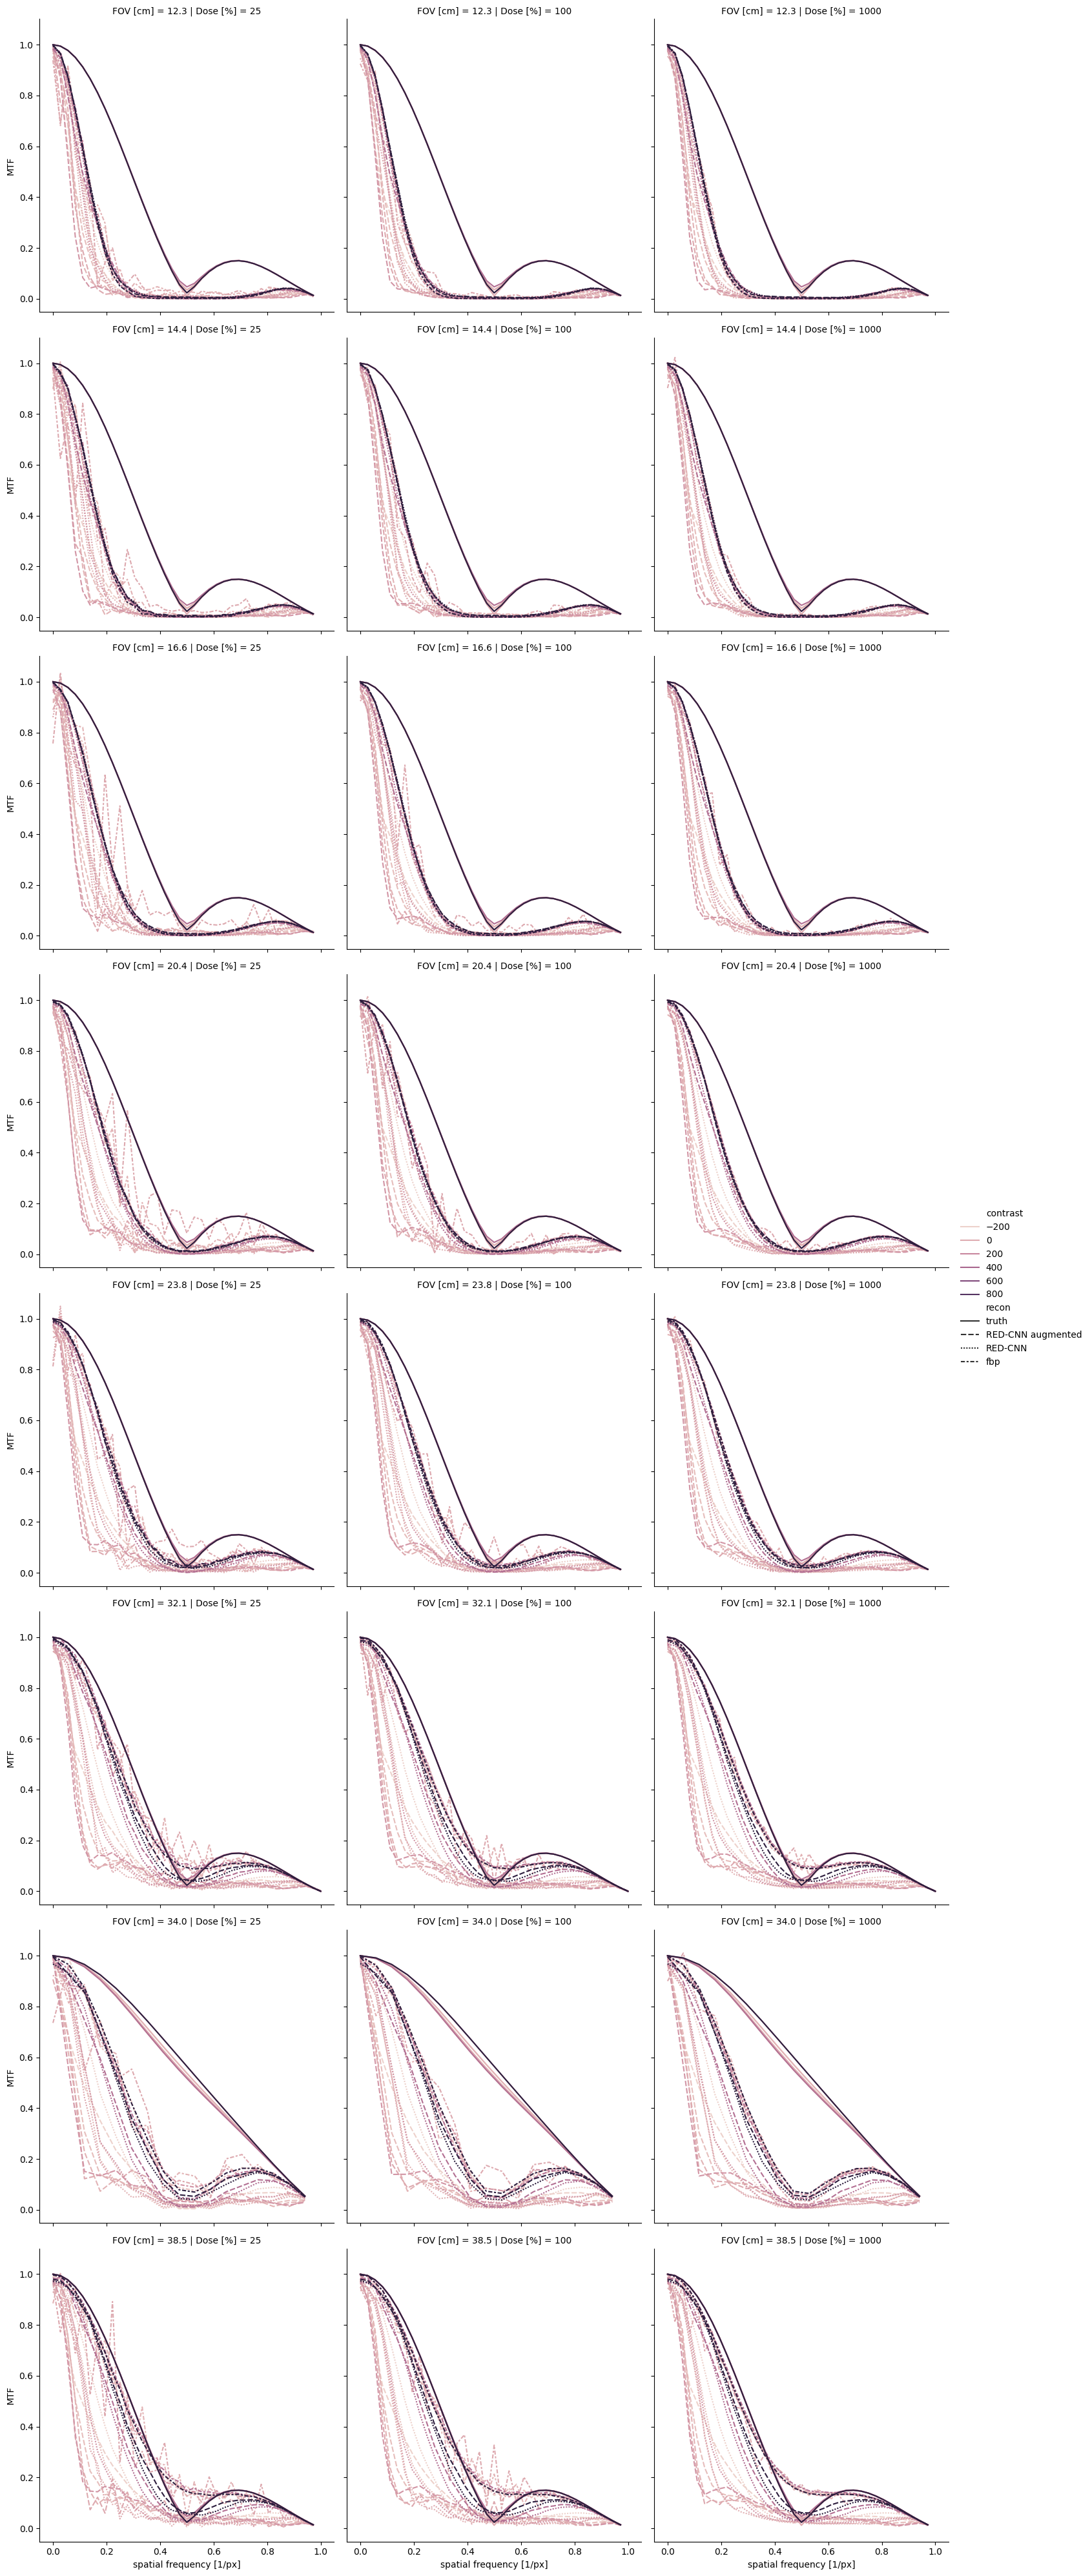

In [52]:
sns.relplot(data=mtf_df[mtf_df['Dose [%]'].isin([25, 100, 1000])], x='spatial frequency [1/px]', y='MTF', hue='contrast', style='recon', kind='line', row='FOV [cm]', col='Dose [%]')

This looks pretty good thought the dip in the ground truth is a little strange, it could be because some of the angles in the radial profile have profiles that are misaligned that is blurring the average, but all together the trends are as expected

<Axes: xlabel='spatial frequency [1/mm]'>

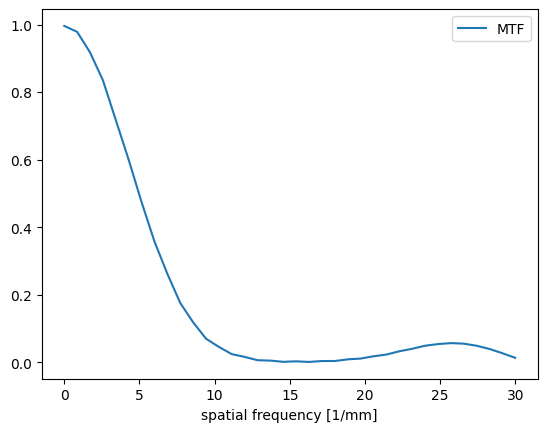

In [53]:
names = mtf_df.name.unique()
name = names[-1]
mtf_df[mtf_df.name == name].plot(x='spatial frequency [1/mm]', y='MTF')

In [54]:
for name in mtf_df.name.unique():
    mtf_df.loc[mtf_df.name == name, 'MTF 10% [1/mm]'] = mtf_df[(mtf_df.name == name)&(mtf_df['MTF']<0.1)].iloc[0]['spatial frequency [1/mm]']
    mtf_df.loc[mtf_df.name == name, 'MTF 10% [1/px]'] = mtf_df[(mtf_df.name == name)&(mtf_df['MTF']<0.1)].iloc[0]['spatial frequency [1/px]']
    mtf_df.loc[mtf_df.name == name, 'MTF 50% [1/mm]'] = mtf_df[(mtf_df.name == name)&(mtf_df['MTF']<0.5)].iloc[0]['spatial frequency [1/mm]']
    mtf_df.loc[mtf_df.name == name, 'MTF 50% [1/px]'] = mtf_df[(mtf_df.name == name)&(mtf_df['MTF']<0.5)].iloc[0]['spatial frequency [1/px]']
mtf_df

name  effective diameter [cm]  FOV [cm]  \
0      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
1      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
2      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
3      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
4      35.0 cm 10% dose truth -200 HU                     35.0      38.5   
...                               ...                      ...       ...   
60475     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
60476     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
60477     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
60478     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   
60479     15.1 cm 85% dose fbp 990 HU                     15.1      16.6   

       Dose [%]  recon  contrast  spatial frequency [1/mm]  \
0            10  truth      -200                  0.000000   
1            10  truth      -200                  0.369408   
2            10  truth      -200                  0.738817   
3            10  truth      -200                  1.108225   
4            10  truth      -200                  1.477633   
...         ...    ...       ...                       ...   
60475        85    fbp       990                 26.559572   
60476        85    fbp       990                 27.416332   
60477        85    fbp       990                 28.273092   
60478        85    fbp       990                 29.129853   
60479        85    fbp       990                 29.986613   

       spatial frequency [1/px]       MTF  MTF 10% [1/mm]  MTF 10% [1/px]  \
0                      0.000000  1.000000        6.279942        0.472222   
1                      0.027778  0.994387        6.279942        0.472222   
2                      0.055556  0.977677        6.279942        0.472222   
3                      0.083333  0.950248        6.279942        0.472222   
4                      0.111111  0.912723        6.279942        0.472222   
...                         ...       ...             ...             ...   
60475                  0.861111  0.055145        9.424364        0.305556   
60476                  0.888889  0.048979        9.424364        0.305556   
60477                  0.916667  0.039493        9.424364        0.305556   
60478                  0.944444  0.026902        9.424364        0.305556   
60479                  0.972222  0.013206        9.424364        0.305556   

       MTF 50% [1/mm]  MTF 50% [1/px]  
0            4.063492        0.305556  
1            4.063492        0.305556  
2            4.063492        0.305556  
3            4.063492        0.305556  
4            4.063492        0.305556  
...               ...             ...  
60475        5.140562        0.166667  
60476        5.140562        0.166667  
60477        5.140562        0.166667  
60478        5.140562        0.166667  
60479        5.140562        0.166667  

[60480 rows x 13 columns]

In [55]:
mtf_df['FOV [cm]'].unique()

array([38.5, 34. , 12.3, 20.4, 23.8, 14.4, 32.1, 16.6])

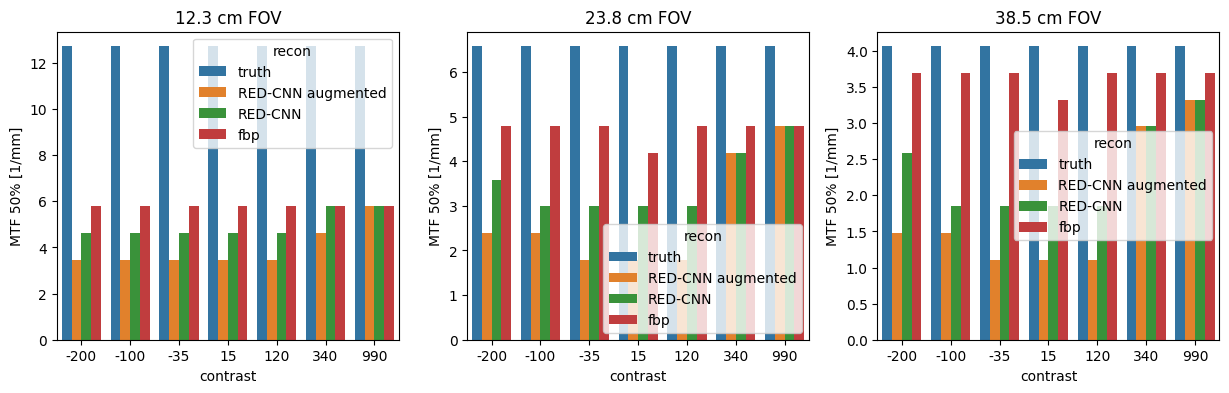

In [56]:
f, axs = plt.subplots(1,3, figsize=(15, 4))
for ax, fov in zip(axs.flatten(), [12.3, 23.8, 38.5]):
    sns.barplot(ax=ax, data=mtf_df[(mtf_df['Dose [%]']==1000)&(mtf_df['FOV [cm]']==fov)], x='contrast', y='MTF 50% [1/mm]', hue='recon')
    ax.set_title(f'{fov} cm FOV')

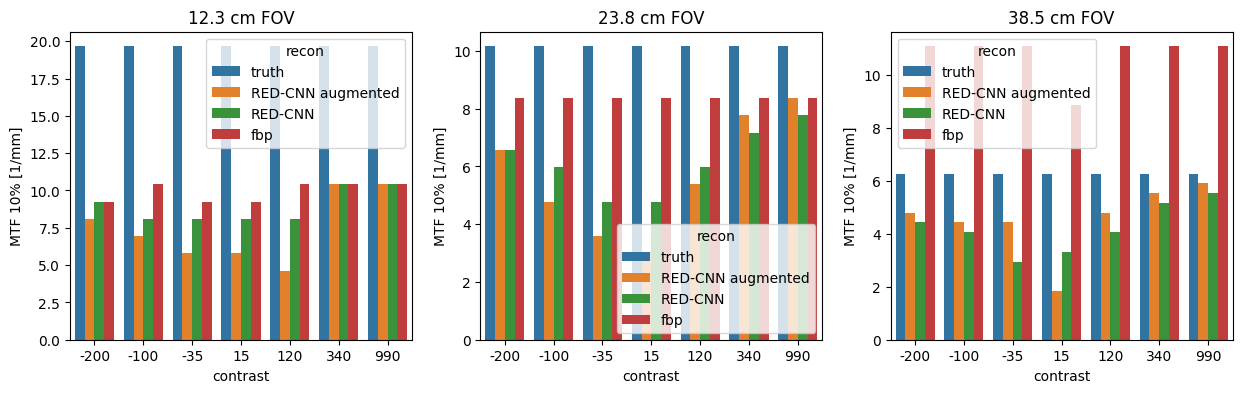

In [57]:
f, axs = plt.subplots(1,3, figsize=(15, 4))
for ax, fov in zip(axs.flatten(), [12.3, 23.8, 38.5]):
    sns.barplot(ax=ax, data=mtf_df[(mtf_df['Dose [%]']==1000)&(mtf_df['FOV [cm]']==fov)], x='contrast', y='MTF 10% [1/mm]', hue='recon')
    ax.set_title(f'{fov} cm FOV')

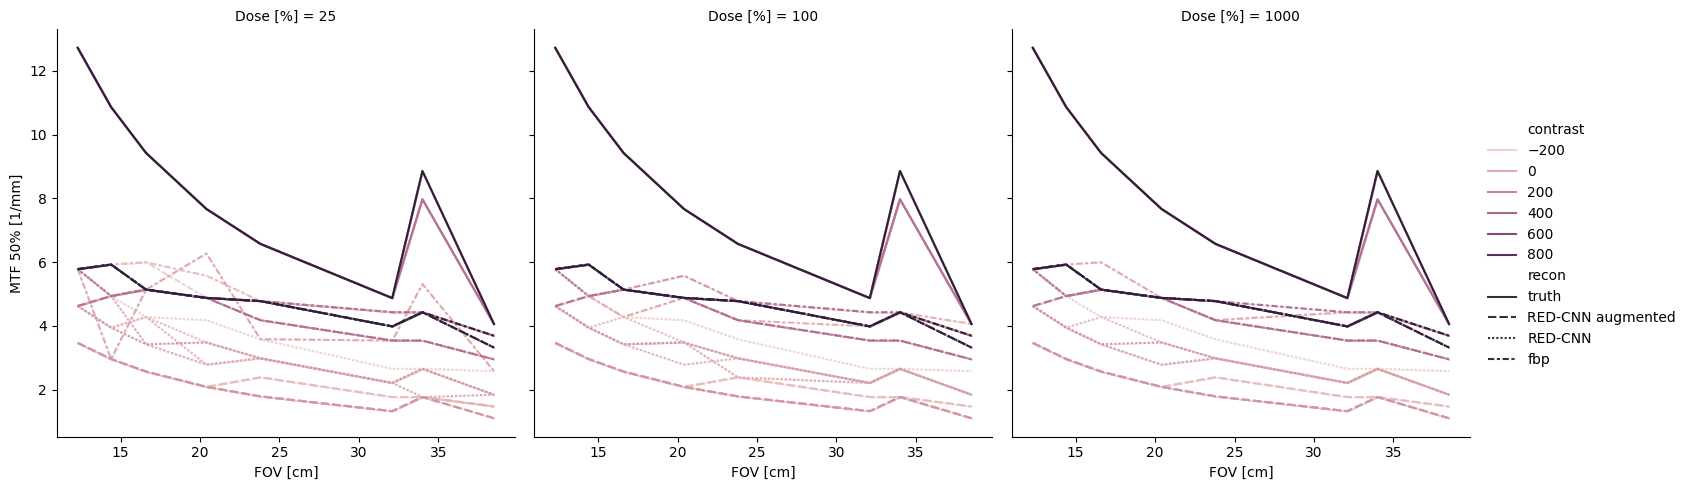

In [58]:
sns.relplot(data=mtf_df[(mtf_df['Dose [%]'].isin([25, 100, 1000]))], x='FOV [cm]', y='MTF 50% [1/mm]', hue='contrast', style='recon', col='Dose [%]', kind='line')

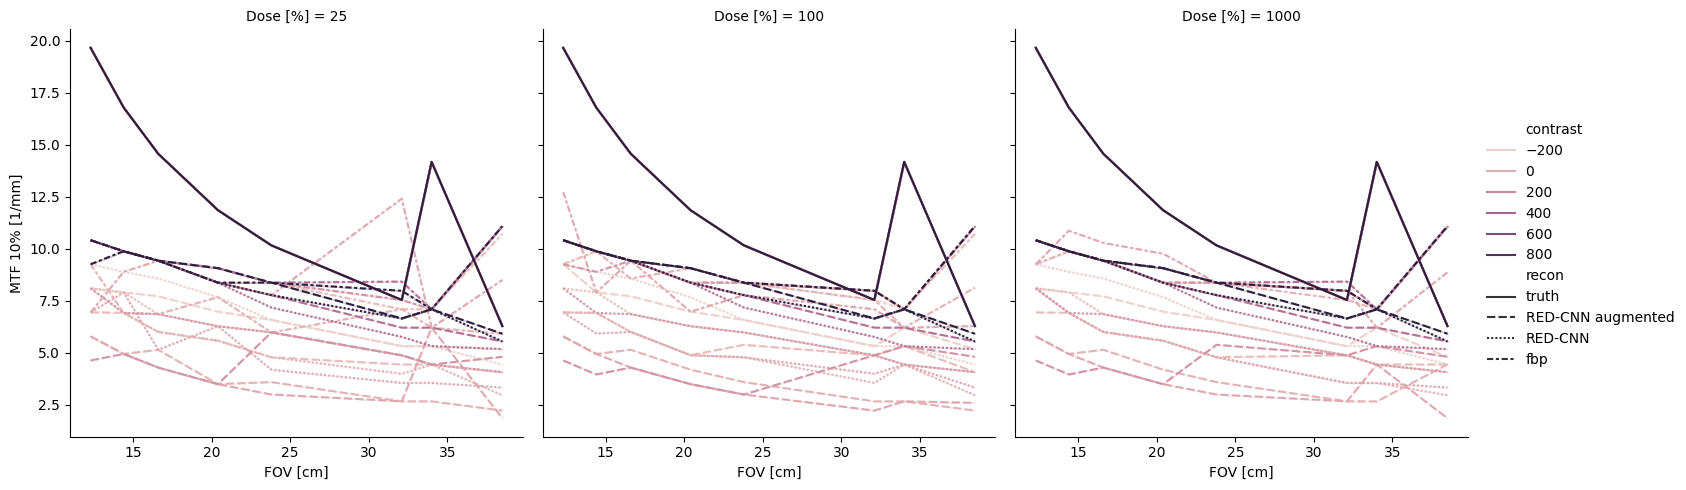

In [59]:
sns.relplot(data=mtf_df[(mtf_df['Dose [%]'].isin([25, 100, 1000]))], x='FOV [cm]', y='MTF 10% [1/mm]', hue='contrast', style='recon', col='Dose [%]', kind='line')

In [60]:
mtf_df.to_csv('mtf.csv', index=False)

In [61]:
mtf_df[(mtf_df['spatial frequency [1/mm]']==0)&(mtf_df['contrast']==-200)&(mtf_df['Dose [%]']==1000)&(mtf_df['spatial frequency [1/mm]']==0)&(mtf_df['recon']!='truth')][['name', 'MTF 10% [1/mm]', 'MTF 50% [1/mm]']]

name  MTF 10% [1/mm]  \
2268   35.0 cm 1000% dose RED-CNN augmented -200 HU        4.802309   
2520             35.0 cm 1000% dose RED-CNN -200 HU        4.432900   
2772                 35.0 cm 1000% dose fbp -200 HU       11.082251   
9135   15.0 cm 1000% dose RED-CNN augmented -200 HU        6.200692   
9254             15.0 cm 1000% dose RED-CNN -200 HU        5.314879   
9373                 15.0 cm 1000% dose fbp -200 HU        7.086505   
14140  11.2 cm 1000% dose RED-CNN augmented -200 HU        8.093948   
14392            11.2 cm 1000% dose RED-CNN -200 HU        9.250226   
14644                11.2 cm 1000% dose fbp -200 HU        9.250226   
22204  18.5 cm 1000% dose RED-CNN augmented -200 HU        6.971678   
22456            18.5 cm 1000% dose RED-CNN -200 HU        7.668845   
22708                18.5 cm 1000% dose fbp -200 HU        9.063181   
30268  21.6 cm 1000% dose RED-CNN augmented -200 HU        6.573296   
30520            21.6 cm 1000% dose RED-CNN -200 HU        6.573296   
30772                21.6 cm 1000% dose fbp -200 HU        8.366013   
38332  13.1 cm 1000% dose RED-CNN augmented -200 HU        7.901235   
38584            13.1 cm 1000% dose RED-CNN -200 HU        8.888889   
38836                13.1 cm 1000% dose fbp -200 HU        9.876543   
46459  29.2 cm 1000% dose RED-CNN augmented -200 HU        5.316719   
46718            29.2 cm 1000% dose RED-CNN -200 HU        5.316719   
46977                29.2 cm 1000% dose fbp -200 HU        7.975078   
54684  15.1 cm 1000% dose RED-CNN augmented -200 HU        7.710843   
54936            15.1 cm 1000% dose RED-CNN -200 HU        8.567604   
55188                15.1 cm 1000% dose fbp -200 HU        9.424364   

       MTF 50% [1/mm]  
2268         1.477633  
2520         2.585859  
2772         3.694084  
9135         1.771626  
9254         2.657439  
9373         4.429066  
14140        3.468835  
14392        4.625113  
14644        5.781391  
22204        2.091503  
22456        4.183007  
22708        4.880174  
30268        2.390289  
30520        3.585434  
30772        4.780579  
38332        2.962963  
38584        4.938272  
38836        5.925926  
46459        1.772240  
46718        2.658359  
46977        3.987539  
54684        2.570281  
54936        4.283802  
55188        5.140562